## Project 3: Transformer

This is the third project in NLP SW07 done by Jannine Meier. 

The project was run on GPUHub.

WandB Project Link with created View options: https://wandb.ai/nlp_janninemeier/Project3_JM?nw=nwuserjanninemeier

### Project description
This project explores the application of a 6-layer vanilla transformer enocder with a single layer classifier to solve two distinct language-based challenges:
- The Winogrande challenge involves selecting the correct option to fill in a blank in a given sentence from two choices. By preprocessing the dataset for a binary classification framework, where each sentence-option pair is processed individually, the model predicts the likelihood of each option being the correct fill-in, aiming to capture the subtleties of human commonsense reasoning.
- The anagram detection is a problem where the task is to identify whether two strings are anagrams of each other. This challenge demands the model to learn the rules and patterns defining anagrammatic relationships at a character level. 

### Libraries & Imports

In [ ]:
# Install libraries
!pip install numpy pandas torch datasets transformers wandb matplotlib scikit-learn seaborn

In [ ]:
# Import standard libraries
import numpy as np
import os
import pandas as pd
import random
import string
import copy
import math
import matplotlib.pyplot as plt
import json


# Import PyTorch related libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
import seaborn as sns

# Import Hugging Face Transformers
from transformers import BertTokenizer

# Import datasets library
from datasets import load_dataset

# Import Weights & Biases
import wandb

# Import scikit-learn utilities
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Set seed for reproducibility
def set_seed(seed_value):
    random.seed(seed_value)  # Python
    np.random.seed(seed_value)  # NumPy
    torch.manual_seed(seed_value)  # PyTorch
    torch.cuda.manual_seed_all(seed_value)  # PyTorch, if you are using CUDA
    # For reproducibility, can also set torch.backends.cudnn.benchmark to False and torch.use_deterministic_algorithms(True)

set_seed(42)

### Preprocessing

**Load Datasets:** The datasets are loaded and split into training, validation, and test sets. The test set for winogrande is made by excluding the last 1000 entries from the full training dataset and form the test set with it.

#### Winogrande specific preprocessing steps

##### Normalize, Tokenize, Encode

- **BERT Model Usage:** Using the BERT model helps with lowercasing, tokenization, conversion to token IDs, the inclusion of special tokens and padding.
- **Uncased Variant:** I chose *uncased* as it ensures that the same words are recognized as the same tokens regardless of their case. Lowercasing will (most likely) not change the meaning of a word in our task and the model might learn the meanings of words more efficiently this way.
- **Punctuation and Stopwords:** Retaining punctuation and stopwords aligns with BERT's training, because they might have potential significance in conveying nuanced meanings. This approach aligns with BERT's comprehension of language structure, including these elements.
- **No Stemming or Lemmatization:** Avoiding stemming or lemmatization capitalizes on BERT's WordPiece tokenization, which adeptly manages word form variations, aligns with BERT's design to interpret words in full context.
- **Sequence Preparation:** Replacing the placeholder `_` with each option creates distinct scenarios for tokenization. This step, followed by sequence length analysis, informs the necessary padding to achieve uniform sequence lengths across the dataset.
- **Token ID Conversion and Special Tokens:** Text conversion into token IDs, supplemented by `[CLS]` and `[SEP]` special tokens, aids in classification tasks. These tokens guide the model in understanding input structure and intent. 
- **Padding and Truncation:** Uniform sequence lengths are achieved by padding sequences to the determined maximum length, avoiding information loss through truncation by ensuring no inputs are cut off.
- **Attention Masks Generation:** Attention masks are generated alongside `input_ids` to indicate to the model which tokens should be attended to and which should be ignored (padding tokens). The mask has the same length as the `input_ids` array, with `1s` for real tokens and `0s` for padding tokens.
- **Output Format:** The preprocessing yields PyTorch tensors of `input_ids` (two seperate input_ids [CLS] s1 [SEP] [PAD] … [PAD] and [CLS] s2 [SEP] [PAD] … [PAD]) and `attention_masks` (two times - one for each input_ids).

##### Processing

- **Data Structure Initialization:** Preparation involves creating empty lists for `input_ids`, `attention_masks`, and `labels`, accommodating the encoded inputs and corresponding labels.
- **Label Mapping:** Original dataset labels ('2' and '1') are mapped to binary ('1' and '0'), conforming to binary classification norms and simplifying model interpretation. I then check which sentence has the correct option filled in and assigne 1 to the correct option and 0 to the incorrect option, separately.
- **Tensor Conversion:** Consolidated preprocessed inputs (Input IDs, attention masks) and labels are structured into PyTorch tensors, facilitating efficient batch processing and model feeding, thereby streamlining subsequent training and evaluation activities.


#### Anagram Specific Preprocessing Steps

##### Normalize, Tokenize, Encode

- **No Standardization/Normalization Needed:** The dataset is pre-cleaned (e.g., lowercased, single characters), eliminating the need for additional standardization or normalization. 
- **Custom CharTokenizer Implementation:** A `CharTokenizer` class is implemented to handle the unique requirements of character-level tokenization for the anagram detection task. This tokenizer maps each character to a unique integer ID, excluding spaces to focus solely on character sequences. 
    - **Special Tokens:**
        - **Padding Token `[PAD]`:** A special token mapped to ID `0`, utilized for padding tokenized sequences to a uniform length. This ensures all inputs can be processed in batches by the model.
        - **Separator Token `<sep>`:** A special token mapped to ID `1`, critical for distinguishing between the two parts of the anagram sequence. Unlike other characters, the separator is preserved during tokenization to maintain the sequence structure, which is essential for analyzing anagram relationships.
- **Dynamic Vocabulary Update:** The `CharTokenizer` dynamically updates its vocabulary (`char_to_id` and `id_to_char` mappings) as new characters are encountered, ensuring comprehensive coverage of the dataset's character set.

##### Processing

- **Max Length Calculation:** Before processing the dataset, the maximum length of tokenized sequences is determined. This step ensures that all sequences can be padded to a consistent length, facilitating efficient model processing.
- **Dataset Transformation:** The dataset is processed to transform text sequences into a structured format compatible with model training:
    - **Input IDs:** Each character in the sequence is converted into its corresponding integer ID, with sequences padded to the maximum length to ensure uniform input sizes.
    - **Attention Masks:** For each sequence, an attention mask is generated to indicate which tokens are actual characters (`1`) and which are padding (`0`). This enables the model to focus on meaningful content and ignore padded areas.
    - **Labels:** The labels are extracted and maintained as they are, assuming they are already in a binary format (`0` or `1`) indicative of whether the sequence is an anagram or not.
- **Return Format:** The processed data is returned as a dictionary containing PyTorch tensors for `input_ids`, `attention_masks`, and `labels`, making it readily usable for model training and evaluation.


### DataLoader Setup
- **Batch size:** I set it as high as possible.
- **Shuffle parameters:** I shuffle the data in the train loader to get better generalization and that it doesn't learn the order of the sentences. 


In [ ]:

# Load winogrande_l dataset

def load_winogrande_dataset():
    """
    Load the Winogrande dataset in large size.
    Returns:
    - wg_train_dataset: Training dataset excluding the last 1000 records.
    - wg_val_dataset: Validation dataset.
    - wg_test_dataset: Last 1000 records of the training dataset as the test set.
    """
    winogrande_dataset = load_dataset('winogrande', 'winogrande_l')
    wg_train_dataset = winogrande_dataset['train'].select(range(len(winogrande_dataset['train']) - 1000))
    wg_val_dataset = winogrande_dataset['validation']
    wg_test_dataset = winogrande_dataset['train'].select(range(len(winogrande_dataset['train']) - 1000, len(winogrande_dataset['train'])))
    return wg_train_dataset, wg_val_dataset, wg_test_dataset

def load_anagram_small_dataset(base_path= 'NLP/SW08'):
    """
    Load the small anagram dataset.
    Parameters:
    - base_path: The directory where the dataset is located.
    
    Returns:
    - Anagram small training, validation, and test datasets.
    """
   
    base_path = os.path.join(base_path, 'anagram_small_')
    train_path = os.path.join(base_path + 'train.csv')
    valid_path = os.path.join(base_path + 'valid.csv')
    test_path = os.path.join(base_path + 'test.csv')
    
    anagram_small_train = pd.read_csv(train_path, header=None, names=['sequence', 'label'])
    anagram_small_valid = pd.read_csv(valid_path, header=None, names=['sequence', 'label'])
    anagram_small_test = pd.read_csv(test_path, header=None, names=['sequence', 'label'])
    return anagram_small_train, anagram_small_valid, anagram_small_test

def load_anagram_large_dataset(base_path= 'NLP/SW08'):
    """
    Load the large anagram dataset.
    Parameters:
    - base_path: The directory where the dataset is located.
    
    Returns:
    - Anagram large training, validation, and test datasets.
    """
    base_path = os.path.join(base_path, 'anagram_large_')
    train_path = os.path.join(base_path + 'train.csv')
    valid_path = os.path.join(base_path + 'valid.csv')
    test_path = os.path.join(base_path + 'test.csv')
    
    anagram_large_train = pd.read_csv(train_path, header=None, names=['sequence', 'label'])
    anagram_large_valid = pd.read_csv(valid_path, header=None, names=['sequence', 'label'])
    anagram_large_test = pd.read_csv(test_path, header=None, names=['sequence', 'label'])
    return anagram_large_train, anagram_large_valid, anagram_large_test


In [22]:
# Print info for winogrande dataset
wg_train_dataset, wg_val_dataset, wg_test_dataset = load_winogrande_dataset()
print(wg_train_dataset[:1])
print("Length train set:", len(wg_train_dataset))
print("Length val set:", len(wg_val_dataset))
print("Length test set:", len(wg_test_dataset))

{'sentence': ["Ian volunteered to eat Dennis's menudo after already having a bowl because _ despised eating intestine."], 'option1': ['Ian'], 'option2': ['Dennis'], 'answer': ['2']}
Length train set: 9234
Length val set: 1267
Length test set: 1000


In [23]:
# Print info for anagram small dataset
anagram_train, anagram_valid, anagram_test = load_anagram_small_dataset()
print(anagram_train.head())
print("Length train set:", len(anagram_train))
print("Length val set:", len(anagram_valid))
print("Length test set:", len(anagram_test))

                                    sequence  label
0  n k e v i t i k x <sep> k v e i n i k t x      1
1                          v l x <sep> l x v      1
2                              x q l <sep> q      0
3                          b p k <sep> k p b      1
4              h b d y v t u <sep> h y v d t      0
Length train set: 1000
Length val set: 500
Length test set: 500


In [24]:
# Print info for anagram large dataset
anagram_train, anagram_valid, anagram_test = load_anagram_large_dataset()
print(anagram_train.head())
print("Length train set:", len(anagram_train))
print("Length val set:", len(anagram_valid))
print("Length test set:", len(anagram_test))

                                        sequence  label
0  z u n o m p j q e e <sep> z q o m j e e p n i      0
1              m m t b m j y <sep> m m b m j t y      1
2      d c x k a o h t u <sep> u a q h c o k d x      0
3                  h z a s s u h <sep> h u s s h      0
4                      q c t p t h <sep> h c t q      0
Length train set: 10000
Length val set: 2000
Length test set: 2000


In [ ]:
# choose which data set to use

dataset_choice = 'as'  # Options: 'wg' for winogrande, 'as' for anagram_small, 'al' for anagram_large

if dataset_choice == 'wg':
    wg_train_dataset, wg_val_dataset, wg_test_dataset = load_winogrande_dataset()
elif dataset_choice == 'as': anagram_train, anagram_valid, anagram_test = load_anagram_small_dataset()
elif dataset_choice== 'al': anagram_train, anagram_valid, anagram_test = load_anagram_large_dataset()
else: print("Invalid dataset choice")
    

In [ ]:
# Winogrande specific preprocessing

if dataset_choice == 'wg':
        
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    # Assuming wg_train_dataset is a list of examples or a similar iterable
    token_lengths = []
    for item in wg_train_dataset:
        # Combine the sentence with both options to cover both cases
        option_1_sentence = item['sentence'].replace('_', item['option1'])
        option_2_sentence = item['sentence'].replace('_', item['option2'])
        
        # Tokenize and add the length
        tokens_option_1 = tokenizer.encode(option_1_sentence, add_special_tokens=True)
        tokens_option_2 = tokenizer.encode(option_2_sentence, add_special_tokens=True)
        
        token_lengths.append(len(tokens_option_1))
        token_lengths.append(len(tokens_option_2))

    # Calculating the maximum sequence length

    max_length = max(token_lengths)

    def encode_wg_examples(sentence, option1, option2, tokenizer, max_length):
        # The tokenizer now directly handles the text without manual lowercasing or punctuation removal
        
        # Replace placeholder with each option and prepare for encoding
        replaced_sentence1 = sentence.replace('_', option1)
        replaced_sentence2 = sentence.replace('_', option2)

        # Using encode_plus to handle padding, truncation, and return a tensor
        inputs_1 = tokenizer.encode_plus(
            replaced_sentence1,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'  # PyTorch tensors
        )
        
        inputs_2 = tokenizer.encode_plus(
            replaced_sentence2,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # Returning the 'input_ids' and 'attention_mask' for both options
        return {
            'input_ids_1': inputs_1['input_ids'].squeeze(0),  # Removing the batch dimension
            'attention_mask_1': inputs_1['attention_mask'].squeeze(0),
            'input_ids_2': inputs_2['input_ids'].squeeze(0),
            'attention_mask_2': inputs_2['attention_mask'].squeeze(0),
        }

def process_wg_dataset(dataset, tokenizer, max_length):
    input_ids_1 = []
    attention_masks_1 = []
    input_ids_2 = []
    attention_masks_2 = []
    label_1 = []  # Correctness label for option 1
    label_2 = []  # Correctness label for option 2

    for item in dataset:
        encoded_inputs = encode_wg_examples(item['sentence'], item['option1'], item['option2'], tokenizer, max_length)
        
        input_ids_1.append(encoded_inputs['input_ids_1'])
        attention_masks_1.append(encoded_inputs['attention_mask_1'])
        input_ids_2.append(encoded_inputs['input_ids_2'])
        attention_masks_2.append(encoded_inputs['attention_mask_2'])
        
        correct_label = int(item['answer']) - 1  # '1' becomes 0 (option 1 is correct), '2' becomes 1 (option 2 is correct)
        
        # Assigning 1 to the correct option and 0 to the incorrect option, separately
        label_1.append(1 if correct_label == 0 else 0)
        label_2.append(1 if correct_label == 1 else 0)

    return {
        'input_ids_1': torch.stack(input_ids_1),
        'attention_masks_1': torch.stack(attention_masks_1),
        'input_ids_2': torch.stack(input_ids_2),
        'attention_masks_2': torch.stack(attention_masks_2),
        'label_1': torch.tensor(label_1),
        'label_2': torch.tensor(label_2),
    }



In [ ]:
# Anagram specific preprocessing

class CharTokenizer:
    def __init__(self):
        self.char_to_id = {"[PAD]": 0, "<sep>": 1}
        self.id_to_char = {0: "[PAD]", 1: "<sep>"}
        self.max_length = 0  # Track the maximum sequence length

    def tokenize(self, text):
        assert text, "Input text for tokenization is empty."
        tokenized_text = []
        for char in text:
            if char == ' ':  # Skip spaces
                continue
            if char not in self.char_to_id:
                # Update mappings if char is new
                new_id = len(self.char_to_id)
                self.char_to_id[char] = new_id
                self.id_to_char[new_id] = char
            tokenized_text.append(self.char_to_id[char])
        return tokenized_text

    def update_max_length(self, length):
        if length > self.max_length:
            self.max_length = length

    def pad_sequence(self, sequence):
        assert sequence, "Input sequence for padding is empty."
        # Add padding up to the max_length
        return sequence + [self.char_to_id["[PAD]"]] * (self.max_length - len(sequence))

    def decode(self, token_ids):
        return ''.join(self.id_to_char[token_id] for token_id in token_ids)


tokenizer = CharTokenizer()

def calculate_max_length(dataframe, tokenizer):
    for _, row in dataframe.iterrows():
        sequence = row['sequence'].strip()  # Trim whitespace to check for non-empty content meaningfully
        assert sequence, "Sequence is empty or contains only whitespace."
        sequence = sequence.replace(' <sep> ', '<sep>')  # Ensure correct tokenization of separator
        tokenized_sequence = tokenizer.tokenize(sequence)
        tokenizer.update_max_length(len(tokenized_sequence))

        
def process_anagram_dataset(dataframe, tokenizer):
    input_ids = []
    attention_masks = []
    labels = []

    for _, row in dataframe.iterrows():
        sequence = row['sequence'].strip()
        assert sequence, "Sequence is empty or contains only whitespace."
        assert 'label' in row and row['label'] in [0, 1], "Invalid label."
        
        sequence = sequence.replace(' <sep> ', '<sep>')  # Ensure correct tokenization of separator
        tokenized_sequence = tokenizer.tokenize(sequence)
        padded_sequence = tokenizer.pad_sequence(tokenized_sequence)
        
        attention_mask = [1 if token_id != tokenizer.char_to_id["[PAD]"] else 0 for token_id in padded_sequence]
        
        input_ids.append(padded_sequence)
        attention_masks.append(attention_mask)
        labels.append(row['label'])

    return {
        'input_ids': torch.tensor(input_ids, dtype=torch.long),
        'attention_masks': torch.tensor(attention_masks, dtype=torch.long),
        'labels': torch.tensor(labels, dtype=torch.long)
    }

In [ ]:
# Choose which dataset to preprocess

if dataset_choice == 'wg':
    # Load the tokenizer
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    
    # Assuming you've defined max_length somewhere above after calculating it
    
    # Load and process the Winogrande datasets
    wg_train_encodings = process_wg_dataset(wg_train_dataset, tokenizer, max_length)
    wg_val_encodings = process_wg_dataset(wg_val_dataset, tokenizer, max_length)
    wg_test_encodings = process_wg_dataset(wg_test_dataset, tokenizer, max_length)

    # Show first dataset sample (demonstrating handling of labels)
    print("Original winogrande training sample:", wg_train_dataset[:1])
    print("Preprocessed wg, opt1, input_ids:", wg_train_encodings['input_ids_1'][0])
    print("Preprocessed wg, opt1, attention_mask:", wg_train_encodings['attention_masks_1'][0])
    print("Preprocessed wg, opt2, input_ids:", wg_train_encodings['input_ids_2'][0])
    print("Preprocessed wg, opt2, attention_mask:", wg_train_encodings['attention_masks_2'][0])
    print("Preprocessed wg, label for option 1:", wg_train_encodings['label_1'][0])  # Corrected to show labels for option 1
    print("Preprocessed wg, label for option 2:", wg_train_encodings['label_2'][0])  # Added to show labels for option 2
    print("Maximum sequence length in the wg dataset:", max_length)
    print("Vocabulary size wg:", len(tokenizer.vocab))

    # Test
    sample_sentence_wg = "The trophy doesn't fit in the suitcase because the _ is too large."
    sample_option1_wg = "trophy"
    sample_option2_wg = "suitcase"
    
    # Process and print the test sample for winogrande
    test_encodings_wg = process_wg_dataset([{'sentence': sample_sentence_wg, 'option1': sample_option1_wg, 'option2': sample_option2_wg, 'answer': '1'}], tokenizer, max_length)
    print("\nProcessed Winogrande test sample, input_ids option1:", test_encodings_wg['input_ids_1'][0])
    print("Processed Winogrande test sample, attention_mask option1:", test_encodings_wg['attention_masks_1'][0])
    print("Processed Winogrande test sample, label for option 1:", test_encodings_wg['label_1'][0])  # Corrected
    print("Processed Winogrande test sample, label for option 2:", test_encodings_wg['label_2'][0])  # Added


   
    
elif dataset_choice in ['as', 'al']:
    # Load the tokenizer
    tokenizer = CharTokenizer() 
    calculate_max_length(anagram_train, tokenizer)
    
    # Load the anagram datasets and process function
    anagram_train_encodings = process_anagram_dataset(anagram_train, tokenizer)
    anagram_val_encodings = process_anagram_dataset(anagram_valid, tokenizer)
    anagram_test_encodings = process_anagram_dataset(anagram_test, tokenizer)
    
    max_length = tokenizer.max_length 
    # Print processed sequences
    print("Processed training sequence example:", anagram_train_encodings['input_ids'][0])
    print("Attention mask for the example:", anagram_train_encodings['attention_masks'][0])
    print("Label for the example:", anagram_train_encodings['labels'][0])
    print("Maximum sequence length in the anagram dataset:", max_length)
    print("Vocabulary size for anagrams:", len(tokenizer.char_to_id))


    # Test
    sample_sequence_anagram = 'm a r y <sep> a r m y' 

    # Process and print the test sample for anagrams
    test_df = pd.DataFrame([{'sequence': sample_sequence_anagram, 'label': 1}])  # Assuming label is known for demonstration
    test_encodings_anagram = process_anagram_dataset(test_df, tokenizer)
    print("\nProcessed anagram test sample, input_ids:", test_encodings_anagram['input_ids'][0])
    print("Processed anagram test sample, attention_mask:", test_encodings_anagram['attention_masks'][0])
    print("Processed anagram test sample, labels:", test_encodings_anagram['labels'][0])  


##### **Output for running winogrande:** 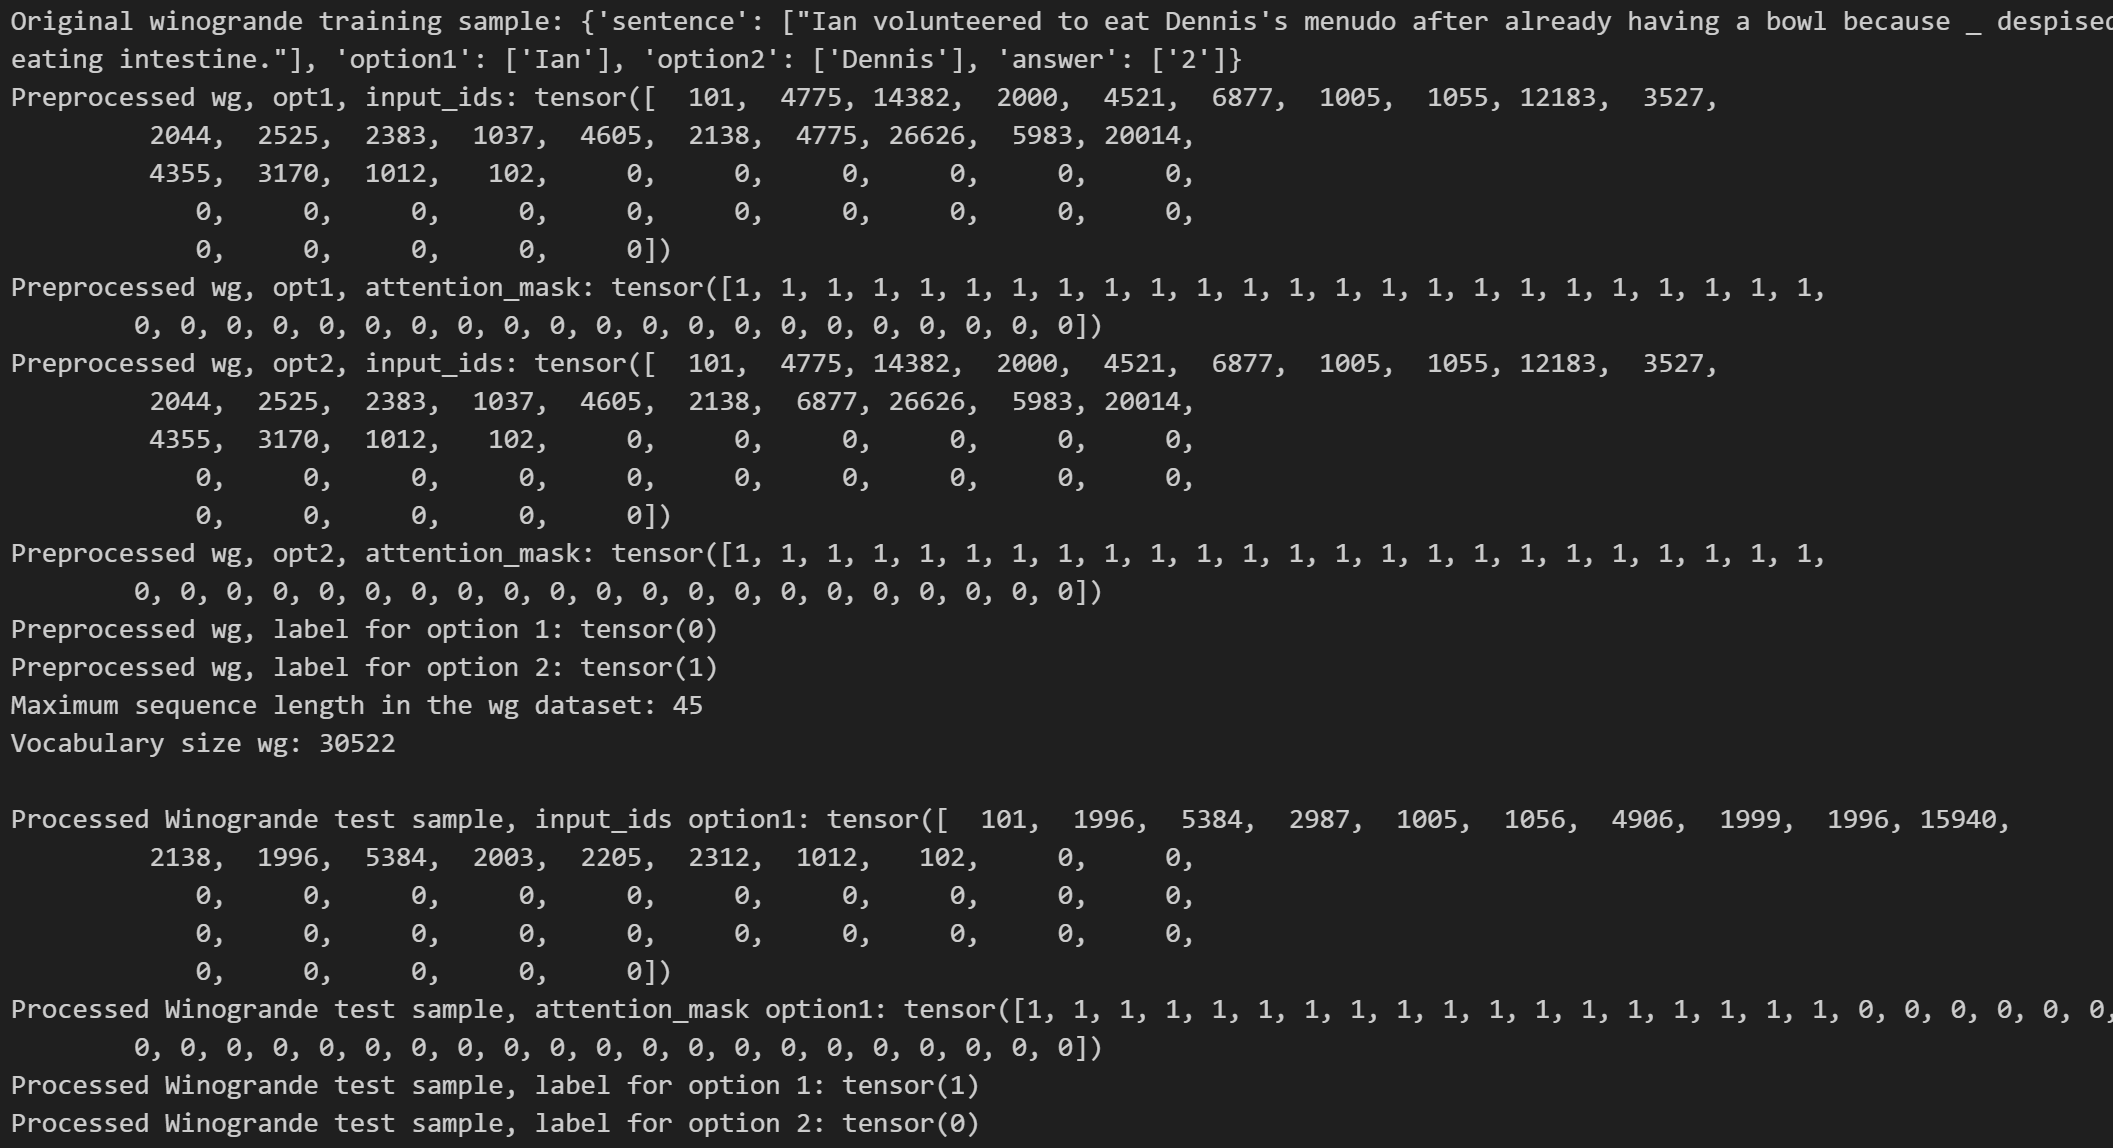

##### **Output for running anagram (small):** 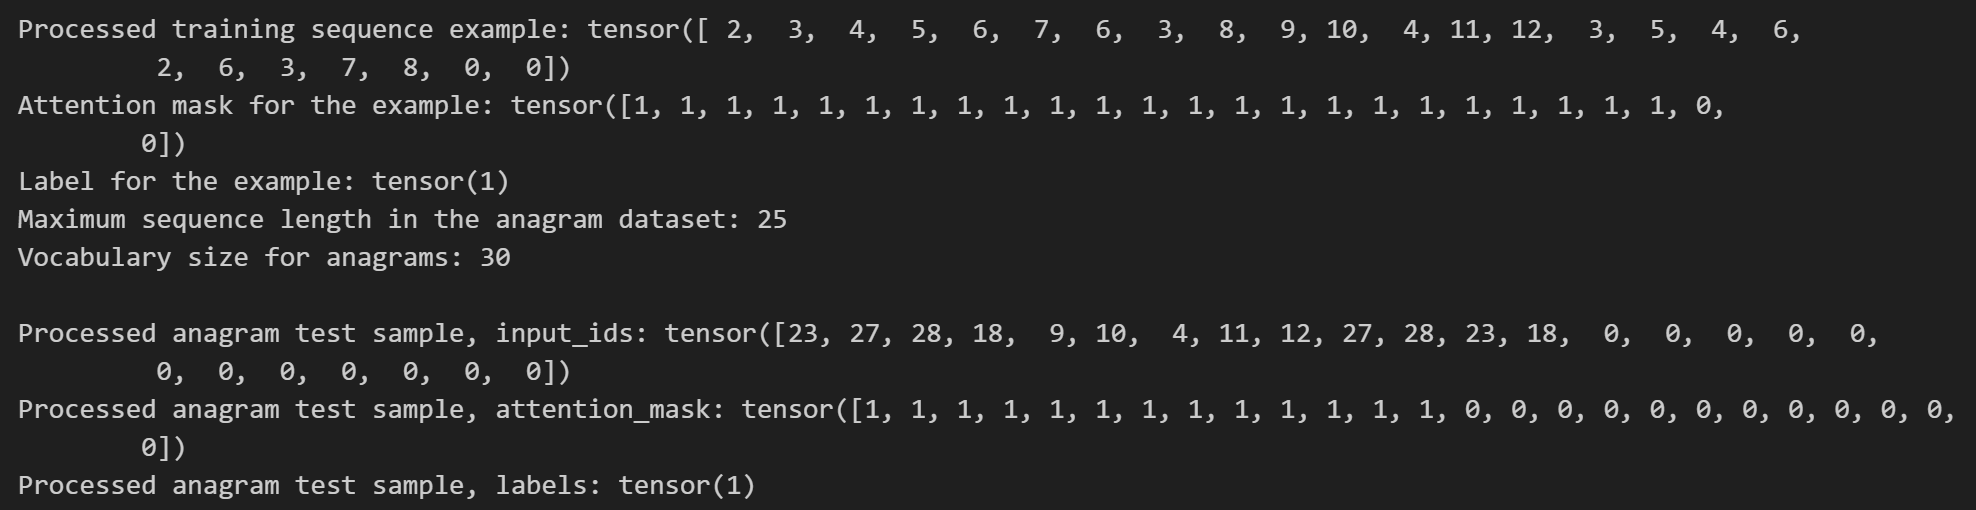

In [ ]:
# DataLoader setup

if dataset_choice == 'wg':
    
    class WinograndeDataset(Dataset):
        def __init__(self, encodings):
            self.encodings = encodings

        def __len__(self):
            # Assuming all keys in the encodings dictionary have the same length
            return len(next(iter(self.encodings.values())))

        def __getitem__(self, idx):
            # Retrieving each item at the specified index
            item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
            return item

    train_dataset = WinograndeDataset(wg_train_encodings)
    val_dataset = WinograndeDataset(wg_val_encodings)
    test_dataset = WinograndeDataset(wg_test_encodings)

    batch_size = 64  # Adjust as per GPU memory

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) 
    valid_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Fetch the first batch from the train_loader
    first_batch = next(iter(train_loader))
    # Now, print the keys and shapes of each item in the batch
    for key, value in first_batch.items():
        print(f"{key}: {value.shape}") 


if dataset_choice in ['as', 'al']:

    class AnagramDataset(Dataset):
        def __init__(self, encodings):
            self.encodings = encodings

        def __len__(self):
            # Assuming all keys in the encodings dictionary have the same length
            return len(self.encodings['input_ids'])

        def __getitem__(self, idx):
            # Retrieving each item at the specified index
            item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
            return item
        
    train_dataset = AnagramDataset(anagram_train_encodings)
    val_dataset = AnagramDataset(anagram_val_encodings)
    test_dataset = AnagramDataset(anagram_test_encodings)

    batch_size = 64  # Adjust as per GPU memory
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) 
    valid_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Fetch the first batch from the train_loader
    first_batch = next(iter(train_loader))
    # Now, print the keys and shapes of each item in the batch
    for key, value in first_batch.items():
        print(f"{key}: {value.shape}") 

##### **Output for running winogrande:** 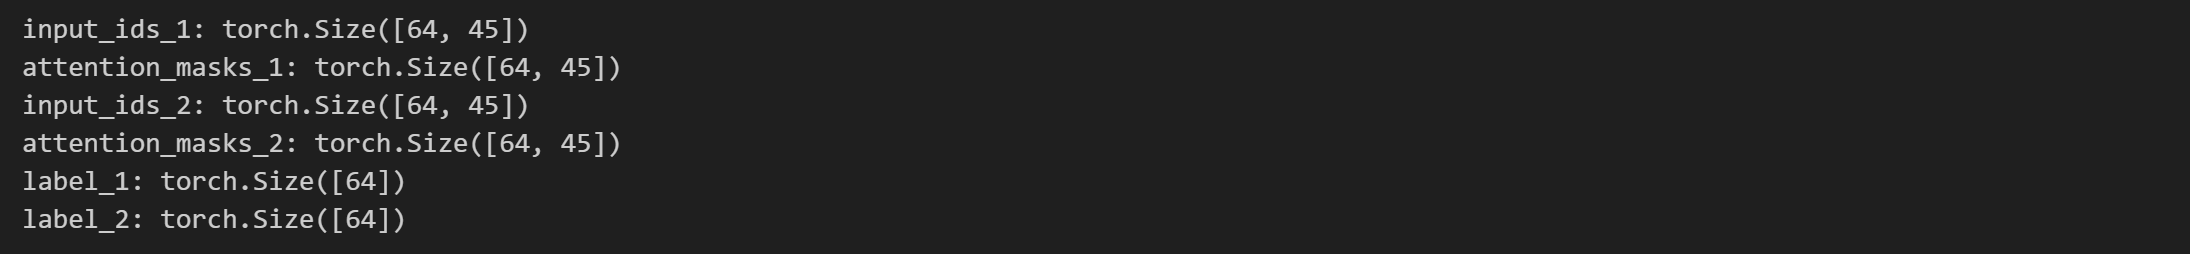
##### **Output for running anagram (small):** 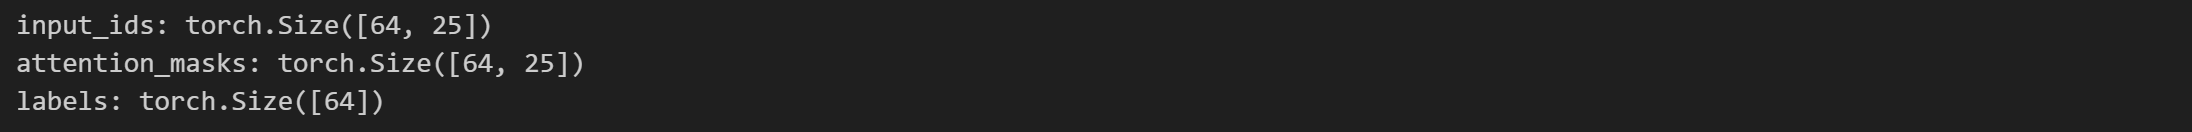

### Model

The TransformerClassifier module encapsulates a complete transformer-based architecture designed for classification tasks. 
- Embedding Layer: I used nn.Embedding to maps input token IDs to vectors.
- Positional Encoding: Since Transformer do not inherently process data in a sequential manner (unlike RNNs), I add positional encoding to incorporate the concept of order. This is crucial for our task where the order of words or tokens affects the meaning of the sentences. I chose to include a dropout layer after adding the positional encodings introduces regularization to further enhancing the model's generalization capabilities.
- Transformer Encoder: The core of the model, consisting of 6 layers and using Pytorchs nn.TransformerEncoderLayer.
- Classification Layer: A linear layer that maps the output of the transformer encoder to the class space.
- Attention Mask Handling: I convert the attention mask to a format expected by the PyTorch TransformerEncoder class (True values where attention should be ignored).
- Classifier Output Activation: I use BCEWithLogitsLoss where the loss function already applies the sigmoid internally.
- Multiplying the embeddings by math.sqrt(self.config['emsize']): This is a practice from the original transformer paper to scale the embeddings. I chose to do it because it helps in balancing the magnitude of the embeddings.

In [ ]:
class PositionalEncoding(nn.Module):
    """
    Injects some information about the relative or absolute position of the tokens 
    in the sequence. The positional encodings have the same dimension as 
    the embeddings, so that the two can be summed. This allows the model to 
    attend to positions, since without this, the model would see a bag of words.
    """
    
    def __init__(self, d_model, dropout, max_len):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Create a long enough positional encoding matrix.
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        # Register pe as a buffer to preserve its state across multiple forward passes
        # and ensure it is not considered a model parameter.
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Applies positional encoding to the input tensor.

        Args:
            x (torch.Tensor): Input tensor of shape [batch_size, seq_len, embedding_dim].
        
        Returns:
            torch.Tensor: Tensor with applied positional encoding, ready for further processing by the model,
                          with the same shape as the input tensor [batch_size, seq_len, embedding_dim].
        """
        # Adjust the positional encoding addition to correctly align with input dimensions
        x = x + self.pe[:, :x.size(1)].transpose(0, 1).to(x.device)
        return self.dropout(x)
    

class TransformerClassifier(nn.Module):
    """
    Implements a Transformer-based classifier for sequence classification tasks.
    This model comprises an embedding layer, positional encoding, a transformer encoder,
    and a linear classification layer.
    """
    def __init__(self, config):
        super(TransformerClassifier, self).__init__()
        self.dimension_size = config['dimension_size']  # Store as an attribute
        
        self.embedding = nn.Embedding(config['vocab_size'], self.dimension_size)
        self.pos_encoder = PositionalEncoding(self.dimension_size, dropout=config['dropout'], max_len=config['max_seq_length'])
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=self.dimension_size,
            nhead=config['nhead'],
            dim_feedforward=self.dimension_size * 4,  # It's common to use a larger size for feedforward layers
            dropout=config['dropout'],
            batch_first=True
        )
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=config['nlayers'])
        self.classifier = nn.Linear(self.dimension_size, 1) # 1 for n output classes
        
        self.init_weights()

    def init_weights(self):
        """Initializes weights of the embedding and classifier layers with uniform distribution."""
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.classifier.weight.data.uniform_(-initrange, initrange)
        self.classifier.bias.data.zero_()

    def forward(self, input_ids, attention_mask=None):
        """Defines the forward pass of the model."""
        # Embedding and scaling using the stored attribute
        src = self.embedding(input_ids) * math.sqrt(self.dimension_size)
        
        # Positional encoding
        src = self.pos_encoder(src)
        
        # Attention mask processing
        if attention_mask is not None:
            attention_mask = attention_mask == 0

        output = self.transformer_encoder(src, src_key_padding_mask=attention_mask)
        output = output.mean(dim=1)
        output = self.classifier(output)
        return output


### Training & Evaluation

I'm' closely following the original Transformer architecture and aiming for simplicity, so I'm making the embedding dimension (emsize) and the hidden dimension size (nhid) the same.

I chose to use Adam as optimizer (same as I in my last project).
I chose to use BCEWithLogitsLoss() again (same as I in my last project) because it aligns with the classification task we have to solve.


In [ ]:
# Set the vocabulary size based on the dataset
vocab_size = len(tokenizer.vocab) if dataset_choice == 'wg' else len(tokenizer.char_to_id)

print(vocab_size)

# Default configuration with the unified dimension size
default_config = {
    'learning_rate': 1e-5,
    'batch_size': 64,
    'num_epochs': 100,
    'dropout': 0.1,
    'optimizer': 'adam',
    'dimension_size': 128,  # This will control both nhid and emsize dynamically
    'nhead': 2,
    'nlayers': 6,
    'nclasses': 1,
    'max_seq_length': max_length,
    'vocab_size': vocab_size,
    'patience': 3,
}


sweep_config = {
    'method': 'bayes',  # Or grid, random
    'metric': {
        'name': 'val_accuracy',
        'goal': 'maximize'
    },
    'parameters': {
        'learning_rate':{'values': [1e-5, 1e-4, 1e-3, 1e-2]},  #{'min': 1e-5, 'max': 1e-2},
        'batch_size': {'values': [64]},
        'num_epochs': {'values': [100]},
        'dropout': {'values': [0.1]},
        'optimizer': {'values': ['adam']}, # Choice of ['adam', 'sgd']
        'dimension_size': {'values': [128, 256, 512]}, # Controlling both nhid and emsize with a single parameter as suggested by you on Ilias Forum
        'nhead': {'values': [2]}, # Number of attention heads
        'nlayers': {'values': [6]}, # Number of transformer encoder layers
        'nclasses': {'values': [1]},  # Number of output classes for binary classification task is 1 with BCEwithLogitsloss
        'max_seq_length': {'values': [max_length]},  # Maximum sequence length for inputs
        'vocab_size': {'value': vocab_size} # To be set based on the tokenizer's vocabulary size
    }
}



In [ ]:
def calculate_accuracy_for_wg(outputs_1, outputs_2, labels_1, labels_2):
    """
    Calculates the accuracy for the Winogrande dataset by comparing each option's
    output against its label. This method is specific to binary classification problems
    where outputs are compared to binary labels.

    Parameters:
    outputs_1 (torch.Tensor): The logits from the model for the first set of samples.
    outputs_2 (torch.Tensor): The logits from the model for the second set of samples.
    labels_1 (torch.Tensor): The ground truth labels for the first set of samples.
    labels_2 (torch.Tensor): The ground truth labels for the second set of samples.

    Returns:
    float: The accuracy of the model on the provided data, calculated as the
           percentage of correct predictions over the total number of samples.
    """
    preds_1 = torch.sigmoid(outputs_1) >= 0.5
    preds_2 = torch.sigmoid(outputs_2) >= 0.5
    correct_1 = preds_1.eq(labels_1).sum().item()
    correct_2 = preds_2.eq(labels_2).sum().item()
    total = len(labels_1) + len(labels_2)  # Total number of predictions
    accuracy = (correct_1 + correct_2) / total
    return accuracy


# Path to the file where best validation accuracies will be saved
accuracy_file_path = 'best_validation_accuracies.json'

def load_best_accuracies():
    """
    Loads the best validation accuracies from a JSON file. This is used to retain
    the history of accuracies across different runs of the training process.

    Returns:
    dict: A dictionary containing the best accuracies keyed by dataset identifiers.
          If the file does not exist, an empty dictionary is returned.
    """
    if os.path.exists(accuracy_file_path):
        with open(accuracy_file_path, 'r') as file:
            return json.load(file)
    else:
        return {}

def save_best_accuracies(accuracies):
    """Save best validation accuracies to a file."""
    with open(accuracy_file_path, 'w') as file:
        json.dump(accuracies, file)

def train(dataset_choice):
    """
    Trains a Transformer model on the specified dataset and logs performance metrics.
    This function handles the training loop, validation, and checkpointing of the best models.

    Parameters:
    dataset_choice (str): Identifier for the dataset. Can be 'wg' for Winogrande, 'as' for Anagram Small,
                          or 'al' for Anagram Large. This affects the data loading and processing within
                          the training and validation loops.

    This function does not return any values but outputs logs and saves model checkpoints.
    """
    global best_validation_accuracies
    wandb.init()
    config = wandb.config
    simple_config = {k: v for k, v in config.items()}

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = TransformerClassifier(config).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])
    loss_fn = torch.nn.BCEWithLogitsLoss()

    best_validation_accuracies = load_best_accuracies()

    # Initialize best_val_accuracy from best_validation_accuracies or set to 0 if not present
    current_best_accuracy = best_validation_accuracies.get(dataset_choice, 0.0)

    dataset_name_map = {'wg': 'winogrande', 'as': 'anagram_small', 'al': 'anagram_large'}
    dataset_name = dataset_name_map.get(dataset_choice, 'unknown_dataset')


    for epoch in range(config['num_epochs']):
        model.train()
        total_loss = 0
        total_accuracy = 0
        num_batches = 0

        for batch in train_loader:
            optimizer.zero_grad()

            if dataset_choice == 'wg':
                inputs_1 = batch['input_ids_1'].to(device)
                inputs_2 = batch['input_ids_2'].to(device)
                labels_1 = batch['label_1'].to(device).float().unsqueeze(1)  # Adjusted for BCELoss
                labels_2 = batch['label_2'].to(device).float().unsqueeze(1)  # Adjusted for BCELoss
                attention_masks_1 = batch.get('attention_masks_1', None).to(device) if 'attention_masks_1' in batch else None
                attention_masks_2 = batch.get('attention_masks_2', None).to(device) if 'attention_masks_2' in batch else None

                outputs_1 = model(inputs_1, attention_masks_1)
                outputs_2 = model(inputs_2, attention_masks_2)
                loss = loss_fn(outputs_1, labels_1) + loss_fn(outputs_2, labels_2)  # Sum of losses
            else:
                inputs = batch['input_ids'].to(device)
                labels = batch['labels'].to(device).float().unsqueeze(1)  # Adjust for BCEWithLogitsLoss
                attention_masks = batch.get('attention_masks').to(device) if 'attention_masks' in batch else None
                outputs = model(inputs, attention_masks)
                loss = loss_fn(outputs, labels)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            # For Winogrande, calculate accuracy differently
            if dataset_choice == 'wg':
                batch_accuracy = calculate_accuracy_for_wg(outputs_1, outputs_2, labels_1, labels_2)
            else:
                preds = torch.sigmoid(outputs) >= 0.5
                batch_accuracy = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())

            total_loss += loss.item()
            total_accuracy += batch_accuracy
            num_batches += 1

        average_train_loss = total_loss / num_batches
        average_train_accuracy = total_accuracy / num_batches



        # Validation loop
        model.eval()
        total_val_loss = 0
        total_val_accuracy = 0
        num_val_batches = 0
        
        with torch.no_grad():
            for batch in valid_loader:
                if dataset_choice == 'wg':
                    inputs_1 = batch['input_ids_1'].to(device)
                    inputs_2 = batch['input_ids_2'].to(device)
                    labels_1 = batch['label_1'].to(device).float().unsqueeze(1)  # Adjusted for BCELoss
                    labels_2 = batch['label_2'].to(device).float().unsqueeze(1)  # Adjusted for BCELoss
                    attention_masks_1 = batch.get('attention_masks_1', None).to(device) if 'attention_masks_1' in batch else None
                    attention_masks_2 = batch.get('attention_masks_2', None).to(device) if 'attention_masks_2' in batch else None

                    outputs_1 = model(inputs_1, attention_masks_1)
                    outputs_2 = model(inputs_2, attention_masks_2)
                    val_loss = loss_fn(outputs_1, labels_1) + loss_fn(outputs_2, labels_2)  # Sum of losses
                else:
                    inputs = batch['input_ids'].to(device)
                    labels = batch['labels'].to(device).float().unsqueeze(1)
                    attention_masks = batch.get('attention_masks').to(device) if 'attention_masks' in batch else None
                    outputs = model(inputs, attention_masks)
                    val_loss = loss_fn(outputs, labels)

                # For Winogrande, calculate accuracy differently
                if dataset_choice == 'wg':
                    val_batch_accuracy = calculate_accuracy_for_wg(outputs_1, outputs_2, labels_1, labels_2)
                else:
                    preds = torch.sigmoid(outputs) >= 0.5
                    val_batch_accuracy = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())

                total_val_loss += val_loss.item()
                total_val_accuracy += val_batch_accuracy
                num_val_batches += 1

            average_val_loss = total_val_loss / num_val_batches
            average_val_accuracy = total_val_accuracy / num_val_batches

            # Checkpoint model if validation accuracy improves
            # Unfortunately this overwrites the best accuracies when a new sweep is started and I could not figure out in time how to correct it
            if average_val_accuracy > current_best_accuracy:
                current_best_accuracy = average_val_accuracy
                best_validation_accuracies[dataset_choice] = current_best_accuracy
                save_best_accuracies(best_validation_accuracies)

                checkpoint_path = f"best_model_{dataset_name}.pt"
                torch.save({
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'best_val_accuracy': current_best_accuracy,
                    'config': simple_config 
                }, checkpoint_path)

                print(f"Saved best model checkpoint for {dataset_name} to {checkpoint_path}")

            wandb.log({"train_loss": average_train_loss, "train_accuracy": average_train_accuracy,
                    "val_loss": average_val_loss, "val_accuracy": average_val_accuracy})
            print(f"Epoch {epoch+1}/{config['num_epochs']}, Train Loss: {average_train_loss:.4f}, Train Accuracy: {average_train_accuracy:.4f} Validation Loss: {average_val_loss:.4f}, Validation Accuracy: {average_val_accuracy:.4f}")


In [ ]:
# Start a sweep

sweep_id = wandb.sweep(sweep_config, project="Project3_with_views_anagram_large")

wandb.agent(sweep_id, lambda: train(dataset_choice), count=10)

### Test

In [ ]:
# Calculate accuracy for winogrande 
def calculate_accuracy_for_wg(preds_1, preds_2, labels_1, labels_2):
    """
    Calculates the accuracy specifically for the Winogrande dataset.
    Expects preds_1, preds_2, labels_1, labels_2 to be PyTorch tensors.
    """
    correct_1 = preds_1.eq(labels_1).sum().item()
    correct_2 = preds_2.eq(labels_2).sum().item()
    total = labels_1.size(0) + labels_2.size(0)  # Total number of predictions
    accuracy = (correct_1 + correct_2) / total
    return accuracy


# Evaluate best model on test set
def evaluate_on_test(model, test_loader, device, dataset_choice):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for batch in test_loader:
            if dataset_choice == 'wg':
                inputs_1 = batch['input_ids_1'].to(device)
                inputs_2 = batch['input_ids_2'].to(device)
                labels_1 = batch['label_1'].to(device)
                labels_2 = batch['label_2'].to(device)
                attention_masks_1 = batch.get('attention_masks_1', torch.zeros_like(inputs_1)).to(device)
                attention_masks_2 = batch.get('attention_masks_2', torch.zeros_like(inputs_2)).to(device)

                outputs_1 = model(inputs_1, attention_masks_1)
                outputs_2 = model(inputs_2, attention_masks_2)

                preds_1 = (torch.sigmoid(outputs_1) >= 0.5).long()
                preds_2 = (torch.sigmoid(outputs_2) >= 0.5).long()

                # Append batch predictions and labels
                all_labels.extend(labels_1.cpu().numpy())
                all_labels.extend(labels_2.cpu().numpy())
                all_preds.extend(preds_1.cpu().numpy())
                all_preds.extend(preds_2.cpu().numpy())
            else:
                inputs = batch['input_ids'].to(device)
                labels = batch['labels'].to(device)
                attention_masks = batch.get('attention_masks', torch.zeros_like(inputs)).to(device)
                outputs = model(inputs, attention_masks)

                preds = (torch.sigmoid(outputs) >= 0.5).long()
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())

    # Calculate accuracy using sklearn's metrics
    accuracy = accuracy_score(all_labels, all_preds)
    conf_matrix = confusion_matrix(all_labels, all_preds)
    print(f"Test accuracy on {dataset_choice}: {accuracy:.4f}")
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(f'Confusion Matrix for {dataset_choice}')
    plt.show()

    return accuracy, conf_matrix

In [ ]:
def save_metrics(accuracy, conf_matrix, dataset_choice):
    accuracy_path = f"test_accuracy_{dataset_choice}.json"
    with open(accuracy_path, 'w') as f:
        json.dump({'accuracy': accuracy}, f)
    
    fig, ax = plt.subplots()
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', ax=ax)
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    ax.set_title(f'Confusion Matrix for {dataset_choice}')
    plt.savefig(f"conf_matrix_{dataset_choice}.png")
    plt.close(fig)

In [ ]:
# Load the best checkpoint
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assuming TransformerClassifier is your model
wandb.init() 
model = TransformerClassifier(config= wandb.config).to(device)


def load_and_evaluate(model, checkpoint_path, test_loader, device, dataset_choice):
    # Load the entire checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device)

    # Extract the model state dictionary from the checkpoint
    model_state_dict = checkpoint['model_state_dict']

    # Load the model state dictionary into the model
    model.load_state_dict(model_state_dict)

    accuracy, conf_matrix = evaluate_on_test(model, test_loader, device, dataset_choice)
    save_metrics(accuracy, conf_matrix, dataset_choice)
    print(f"Loaded model from {checkpoint_path} and evaluated on {dataset_choice}. Test accuracy: {accuracy:.4f}")


# Example usage
if dataset_choice == 'wg':
    checkpoint_path = "best_model_winogrande.pt"
elif dataset_choice == "as":
    checkpoint_path = "best_model_anagram_small.pt"
elif dataset_choice == "al":
    checkpoint_path = "best_model_anagram_large.pt"
else:
    raise ValueError("Invalid dataset choice")

load_and_evaluate(model, checkpoint_path, test_loader, device, dataset_choice)

In [27]:
from IPython.display import Image

def load_test_accuracy(dataset_choice):
    accuracy_path = f"test_accuracy_{dataset_choice}.json"
    with open(accuracy_path, 'r') as f:
        accuracy_data = json.load(f)
        if dataset_choice == "wg":
            print(f"Test accuracy on {dataset_choice}: {0.001* accuracy_data['accuracy']:.4f}")
        else:
            print(f"Test accuracy on {dataset_choice}: {accuracy_data['accuracy']:.4f}")
    return accuracy_data['accuracy']


def display_conf_matrix(dataset_choice):
    return Image(filename=f"conf_matrix_{dataset_choice}.png")


In [ ]:
def print_best_validation_accuracy(dataset_choice):
    dataset_names = {'wg': 'Winogrande', 'as': 'Anagram Small', 'al': 'Anagram Large'}
    dataset_name = dataset_names.get(dataset_choice, 'Unknown Dataset')
    accuracy = best_validation_accuracies.get(dataset_choice)
    if accuracy is not None:
        print(f"Best validation accuracy for {dataset_name}: {accuracy:.4f}")
    else:
        print(f"No accuracy recorded for {dataset_name}")


### Results

Best validation accuracy for Winogrande: 0.5095
Test accuracy on wg: 0.5000


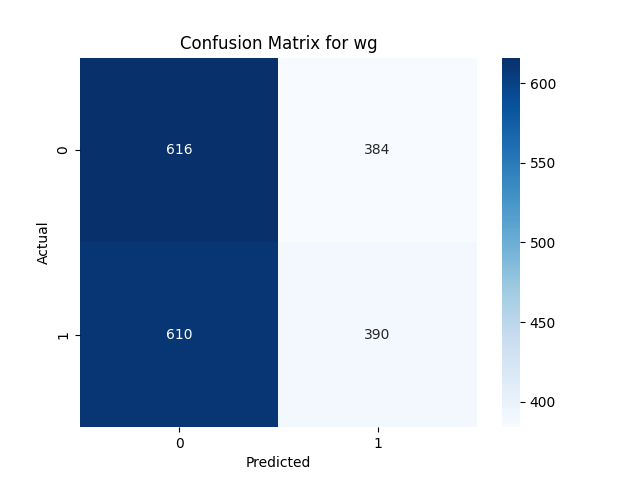

In [28]:
print_best_validation_accuracy("wg")
load_test_accuracy("wg")
display_conf_matrix("wg")

Best validation accuracy for Anagram Small: 0.5598
Test accuracy on as: 0.5360


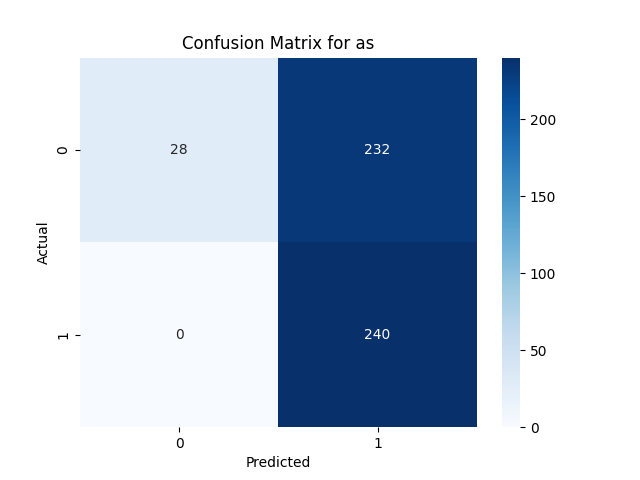

In [26]:
print_best_validation_accuracy("as")
load_test_accuracy("as")
display_conf_matrix("as")

Best validation accuracy for Anagram Large: 0.9849
Test accuracy on al: 0.9720


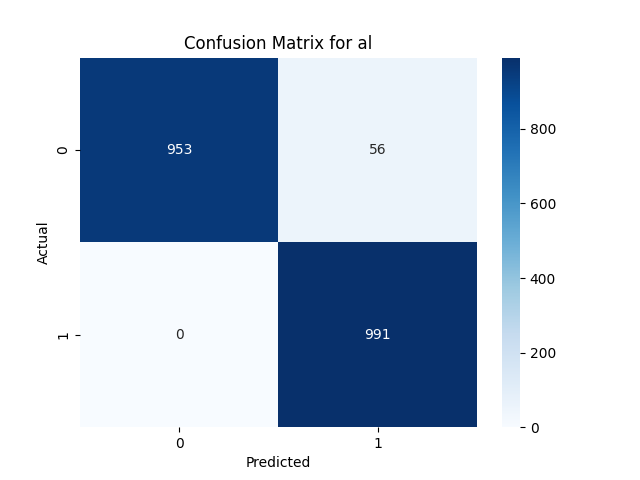

In [29]:
print_best_validation_accuracy("al")
load_test_accuracy("al")
display_conf_matrix("al")

### Interpretation 

First of all I want to mention that I had some problems saving the best model checkpoints and calling them for the testset as it sometimes was overriden by a new sweep . This is something I definitley have to tackle for the next project to get it right and also to then show validation and test accuracies alongside. Due to the time constraints I was not able to finish this as planned because I spent way too much time on setting up and debugging the transformer model. Therefore the actual best accuracies are only shown in the wandb plots but the used best models for the test set are not far from the best value.  The confusion matrix was therfore also not built on the best accuracy model. In the Interpretation I also put in the actual best validation accuracy just to compare

##### Winogrande
Notebook Best validation accuracy for Winogrande: 0.5095
Acutal Best validation accuracy for Winogrande: 0.5095
Test accuracy on wg: 0.5000

In the last project my model was predicting all samples as belonging to either all in class 0 or all in class 1, regardless of the true label. Now it does no longer do this, but it still shows no signs of learning as not even the train accuracy improves over time. I tried out many learning rates and hidden layer sizes but could not manage to improve the outcome. After that I changed the loss function from CrossEntropy to BCEwithlogitloss but my time was already a bit short and I therefore couldn't manage to do many runs with the new setup. I definitly would need more runs to make a good interpretation. Also longer epochs would help but as I have not really seen the validation loss change a lot, this probably would not help too much. As I talked to other students and they were also not able to get a higher score in this task I guess it could be that the task is still just too complex for my 6-layer transformer encoder and we might need some more layers or better transformer models. So unfortunately I was only able to get a test accuracy of 50%.


##### Anagram 
Notebook Best validation accuracy for Anagram Small: 0.5598
Actual Best validation accuracy for Anagram Large: 0.5643
Test accuracy on as: 0.5360

For the small data set, same as in my last project, my loss functions do not decrease and my accuracies do not get better. There are only small de/increases noticable. It looks like the model is not actually learning anything from the data. Nevertheless I tested the best model on my test set and I got an accuracy of 53.60% which is similar to the 50.07% in my last project. 

Notebook Best validation accuracy for Anagram Large: 0.9849
Actual Best validation accuracy for Anagram Large: 0.9999
Test accuracy on al: 0.9720

For the big data see more promising results. I see that the model learns very good. Already after 30 epochs I have above 90% accuracy on both train and validation set. I noticed that a low learning rate (1e-4 and 1e-5) are best fits for the model to learn. For the hidden dimension it doesn't seem to affect the results too much as I get to 99% accuracy after some time no matter if I chose 128, 256 or 512 hidden dimension size. The fastest convergence to 99% I with 256 but I have to admit that due to time constraints I wasn't able to do as much runs as I wanted to do.

These results show me that my assumption in the last project was right -> that the bigger data set for anagram was indeed crucial to get a good performance.


This implementation is inspired by the original Transformer paper ("Attention Is All You Need") and follows some of the encoding formula described therein. I also used ChatGPT to help me clean up my code.

Plots again if they are lost while running:

winogrande: 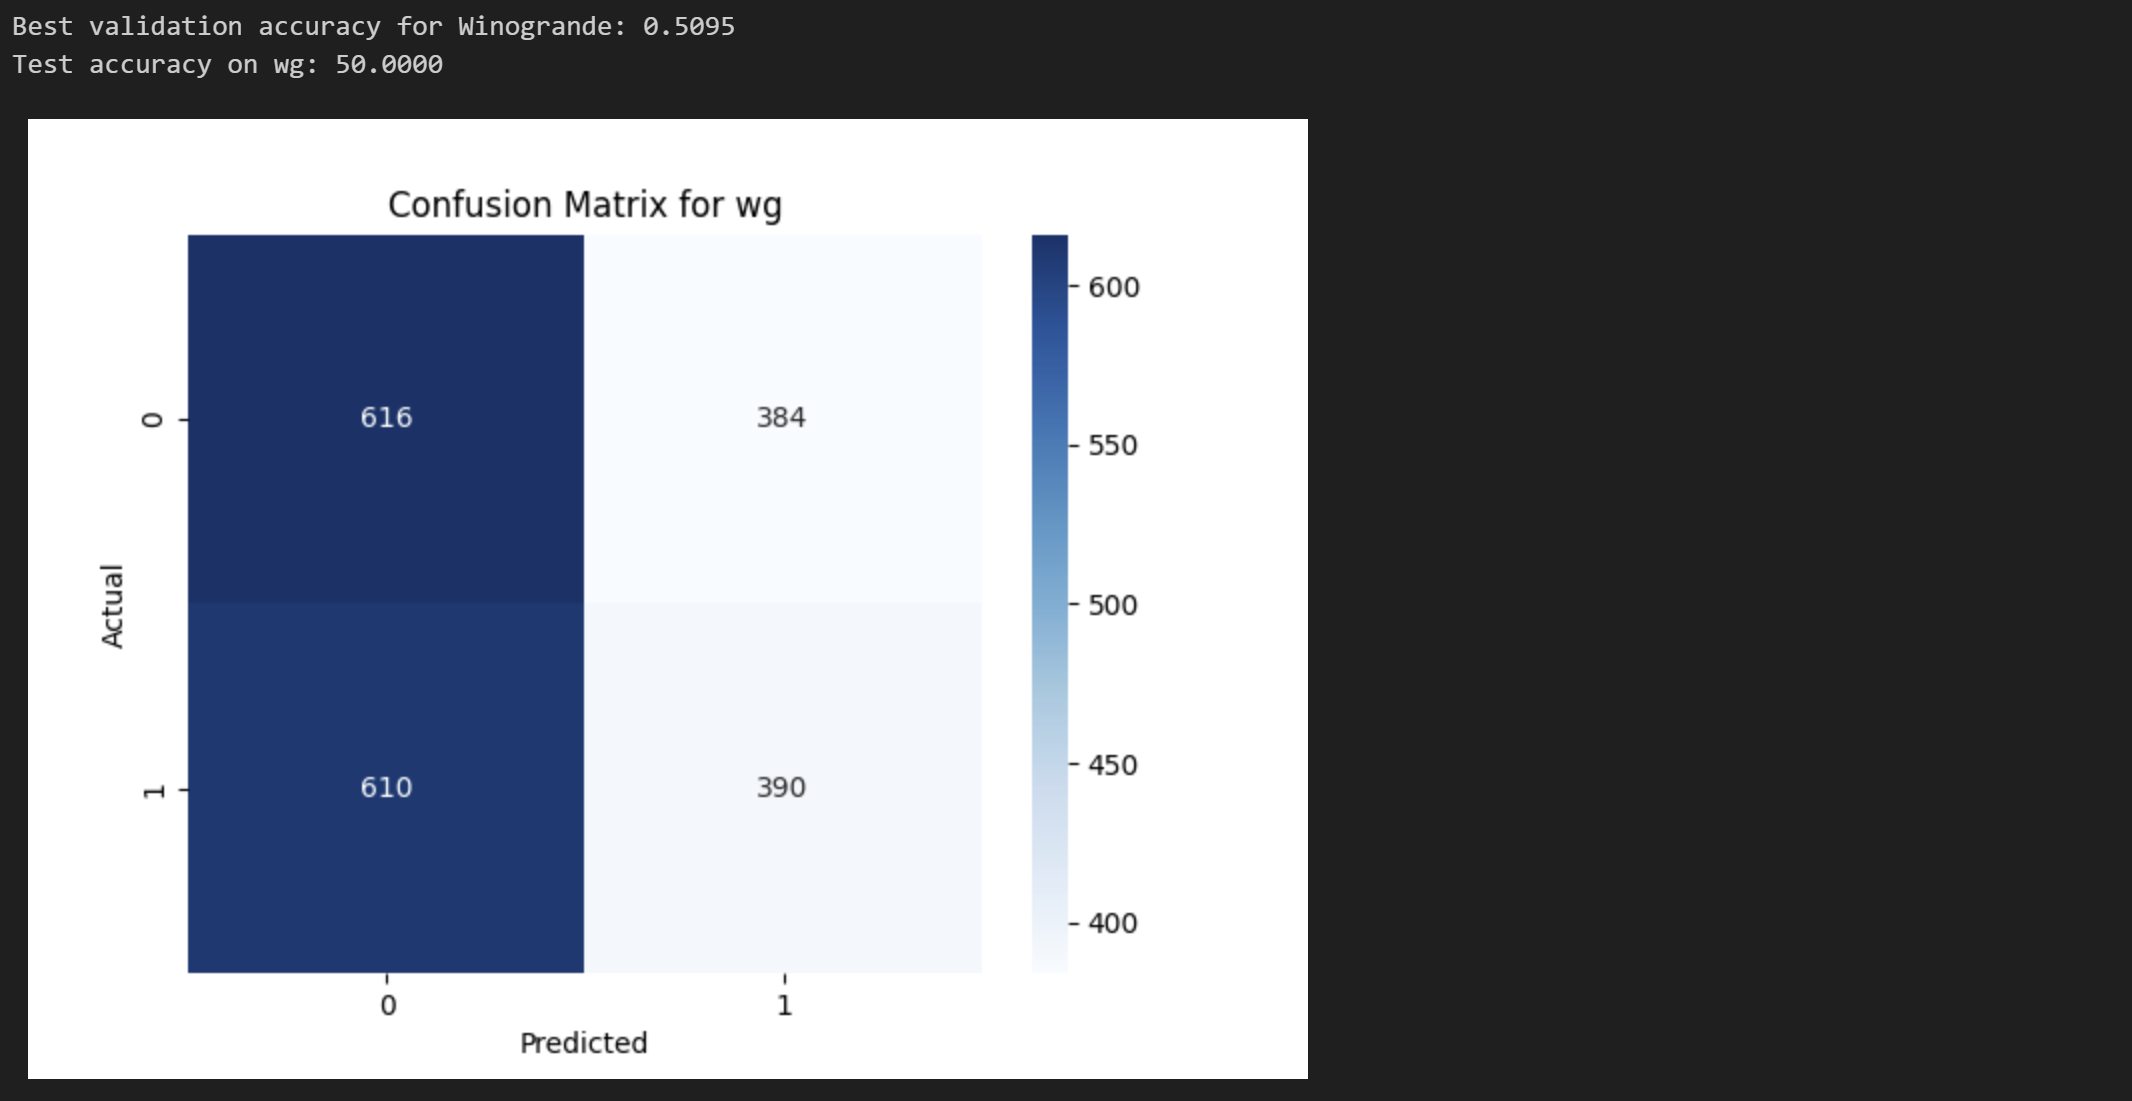
anagram small: 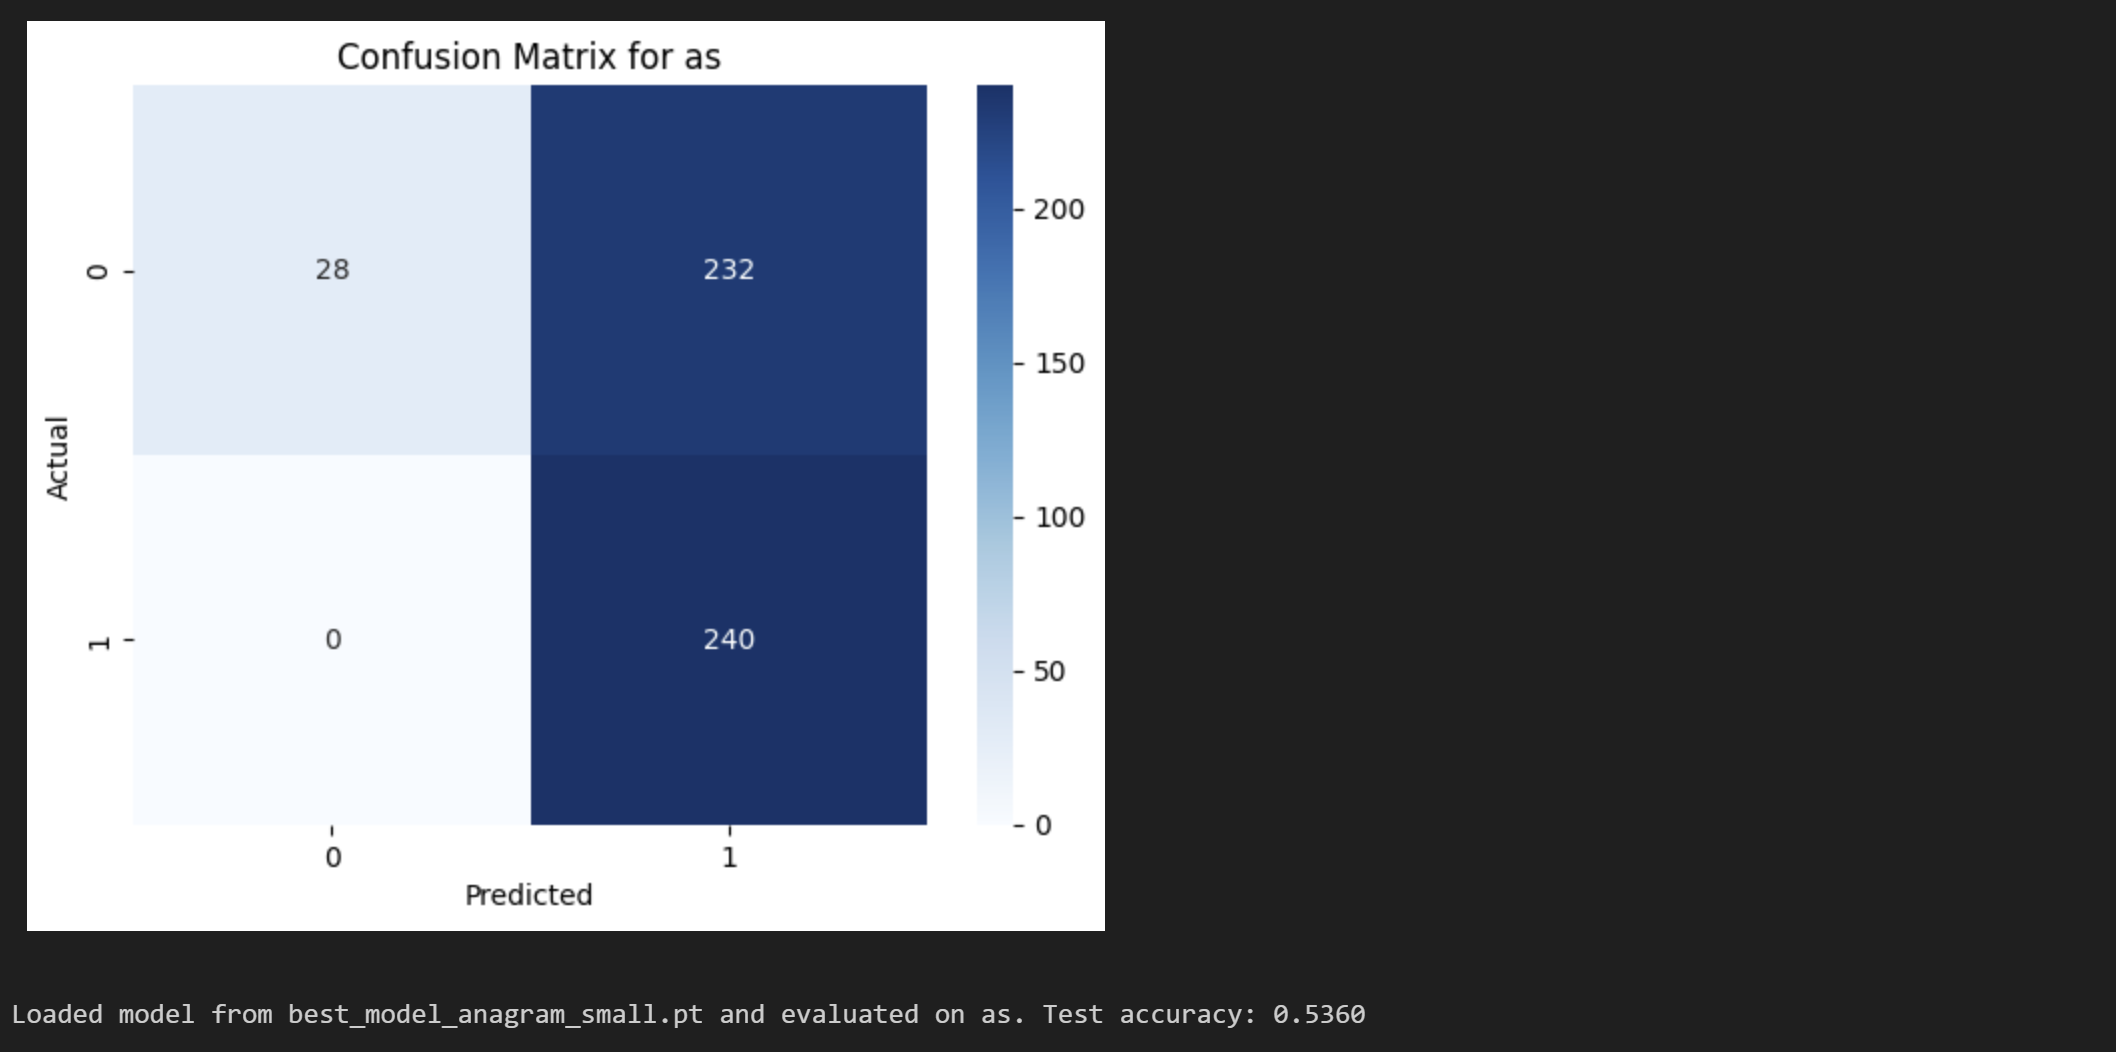
anagram large: 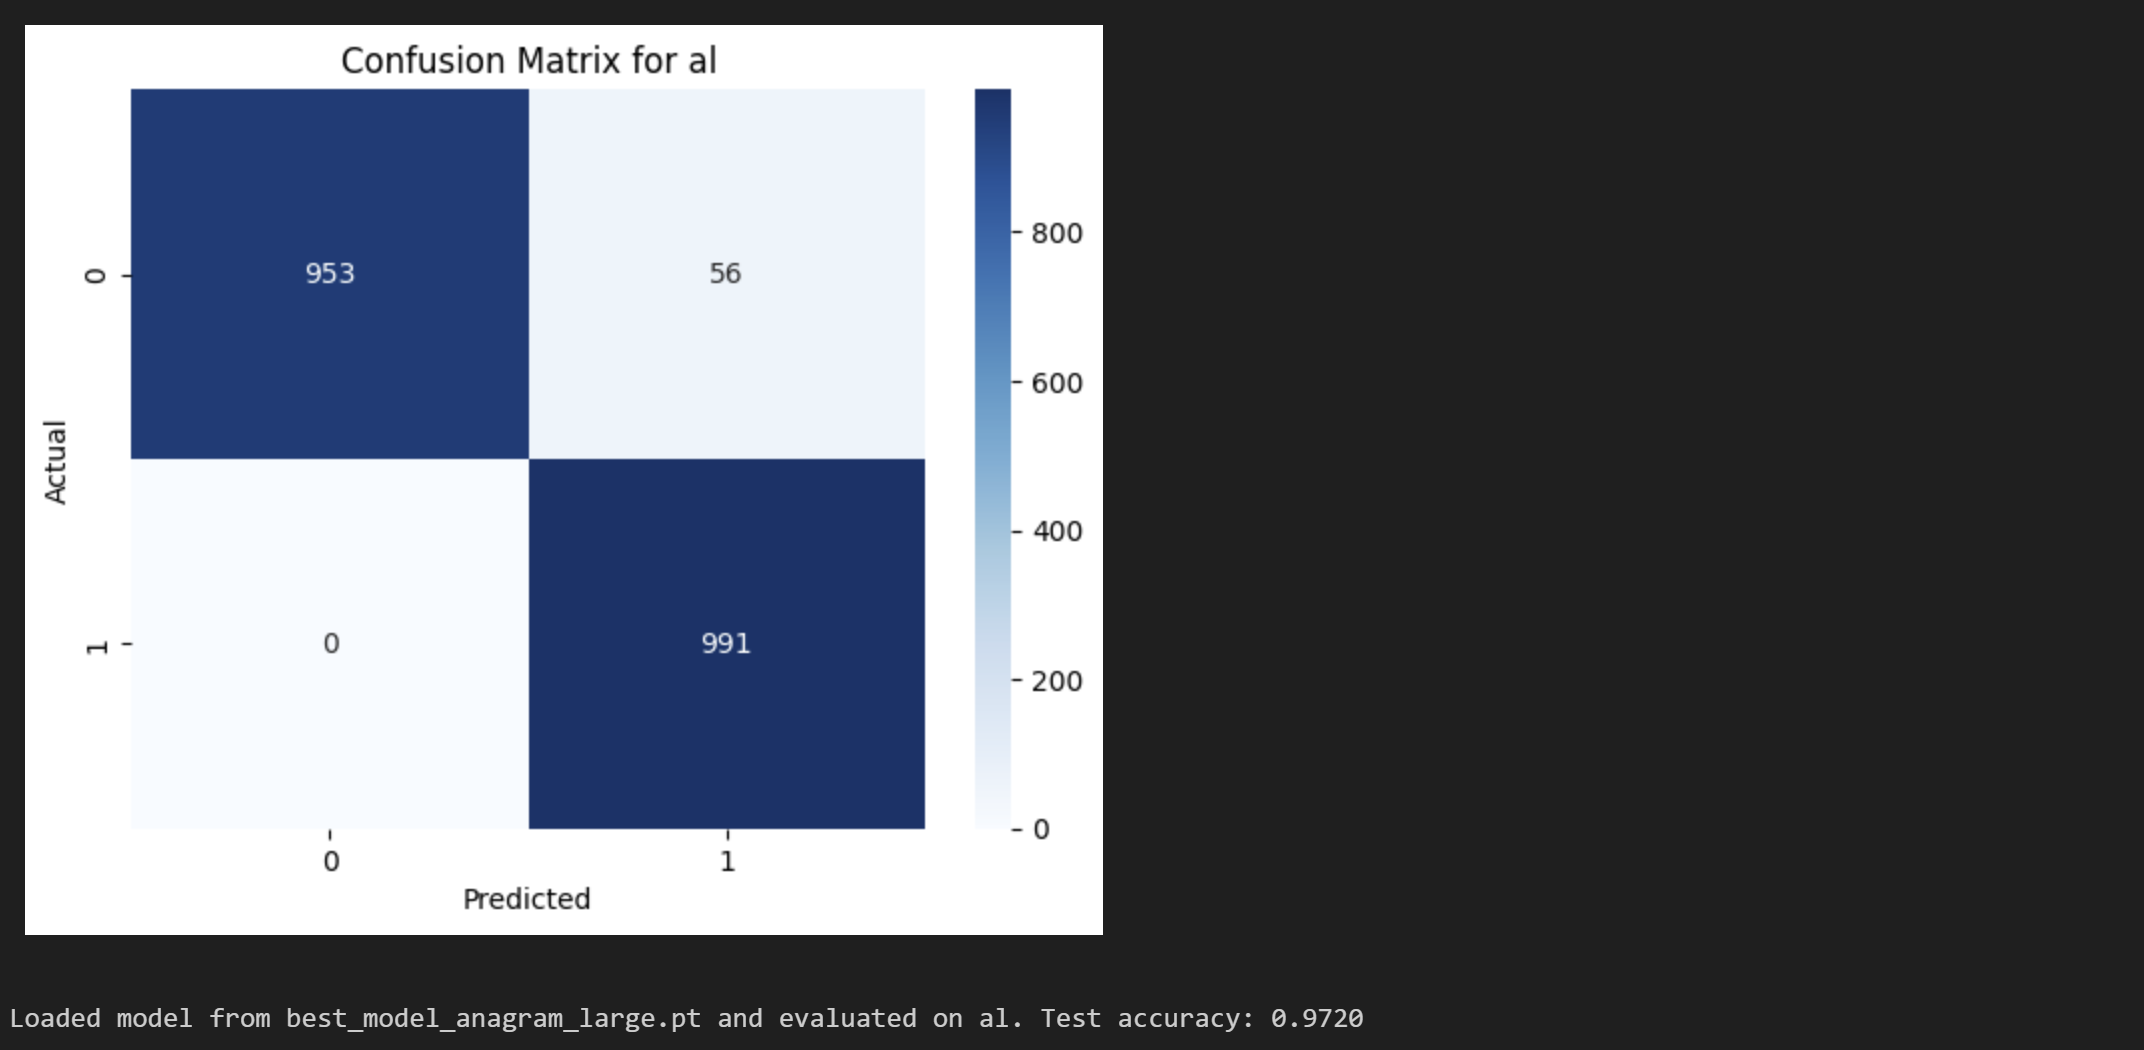